In [1]:
# パッケージのインストール（初回のみ実行）
using Pkg
Pkg.activate(".")  # 現在のディレクトリの環境をアクティブ化
#Pkg.add("ITensors")  # ITensorsパッケージをインストール

  Activating project at `c:\Users\ito23\Documents\学院科目\物性物理学特論Ⅰ\Julia\day4\Mypackage`


In [2]:
using ITensors
using Plots
using LaTeXStrings

In [3]:
# スカラー付き規格化テンソル構造体の定義
struct NormalizedTensor
    tensor::ITensor
    norm::Float64
end

In [4]:
# 規格化テンソルの作成
function normalize_tensor(T::ITensor)
    norm_T = norm(T)

    return NormalizedTensor(T / norm_T, norm_T)
end

normalize_tensor (generic function with 1 method)

In [ ]:
# 縮約の計算
function contract_tensors(A::NormalizedTensor, B::NormalizedTensor)
    T_tensor = A.tensor * B.tensor
    norm_T = norm(T_tensor)
    T_normalized = T_tensor / norm_T
    norm = A.norm * B.norm * norm_T
    return NormalizedTensor(T_normalized, norm)
end


In [ ]:
# 4脚テンソルの生成
function tensor_4legs(K::Float64, i::Index, j::Index, k::Index, l::Index)
    W = ITensor(i, j, k, l)
    
    for ii in 0:1, jj in 0:1, kk in 0:1, ll in 0:1
        W[i => ii+1, j => jj+1, k => kk+1, l => ll+1] = exp(K * ((2 * ii - 1) * (2 * jj - 1) + (2 * jj - 1) * (2 * kk - 1) + (2 * kk - 1) * (2 * ll - 1) + (2 * ll - 1) * (2 * ii - 1)))
    end

    return W
end

J = 1.0
k_B = 1.0
T_C = 2.0 
K = J / k_B / T_C
W = tensor_4legs(K, i, j, k, l)
println(T_C)
@show W

In [ ]:
# 3脚テンソルの生成
function tensor_2legs(W::ITensor, l::Index)
    P = W * delta(l)
    
    return P
end

P = tensor_2legs(W, l)
@show P

In [ ]:
# 2脚テンソル生成
function tensor_2legs(P::ITensor, k::Index)
    C = P * delta(k)

    return C
end

C = tensor_2legs(P, k)
@show C

In [ ]:
# 原始テンソルの生成(自由端)
function tensor_origin_free(K::Float64, i::Index, j::Index, k::Index, l::Index)
    W = ITensor(i, j, k, l)
    
    for ii in 0:1, jj in 0:1, kk in 0:1, ll in 0:1
        W[i => ii+1, j => jj+1, k => kk+1, l => ll+1] = exp(K * ((2 * ii - 1) * (2 * jj - 1) + (2 * jj - 1) * (2 * kk - 1) + (2 * kk - 1) * (2 * ll - 1) + (2 * ll - 1) * (2 * ii - 1)))
    end

    P = W * delta(l)

    C = P * delta(k)

    NW = normalize_tensor(W)
    NP = normalize_tensor(P)
    NC = normalize_tensor(C)

    return NW, NP, NC
end

In [5]:
# 原始テンソルの生成(固定端)
function tensor_origin_fix(K::Float64, i::Index, j::Index, k::Index, l::Index)
    W = ITensor(i, j, k, l)
    
    for ii in 0:1, jj in 0:1, kk in 0:1, ll in 0:1
        W[i => ii+1, j => jj+1, k => kk+1, l => ll+1] = exp(K * ((2 * ii - 1) * (2 * jj - 1) + (2 * jj - 1) * (2 * kk - 1) + (2 * kk - 1) * (2 * ll - 1) + (2 * ll - 1) * (2 * ii - 1)))
    end

    del_l = ITensor(l)
    del_l[l => 2] = 1.0

    P = W * del_l

    del_k = ITensor(k)
    del_k[k => 2] = 1.0

    C = P * del_k

    NW = normalize_tensor(W)
    NP = normalize_tensor(P)
    NC = normalize_tensor(C)

    return NW, NP, NC
end

tensor_origin_fix (generic function with 1 method)

In [41]:
# Pの拡大
function expand_tensor_3legs(W::NormalizedTensor, P::NormalizedTensor, i::Index, j::Index, k::Index, l::Index)
    inds_P = inds(P.tensor)
    n = dim(inds_P[1])

    p = Index(n, "p")
    q = Index(n, "q")

    inds_new_P = [p, l, q]

    P_b = replaceinds(P.tensor, inds_P, inds_new_P)

    P_a = P_b * W.tensor

    P_expanded = combiner(i, p; tags="x") * P_a * combiner(k, q; tags="y")

    NP_expanded = normalize_tensor(P_expanded)

    norm = NP_expanded.norm * P.norm * W.norm

    return NormalizedTensor(NP_expanded.tensor, norm)
end

expand_tensor_3legs (generic function with 1 method)

In [34]:
# Cの拡大
function expand_tensor_2legs(W::NormalizedTensor, P::NormalizedTensor, C::NormalizedTensor, i::Index, j::Index, k::Index, l::Index)
    inds_P = inds(P.tensor)
    inds_C = inds(C.tensor)
    n = dim(inds_P[1])

    p = Index(n, "p")
    q = Index(n, "q")
    r = Index(n, "r")
    s = Index(n, "s")

    inds_new_P_L = [p, l, q]
    inds_new_P_R = [r, k, s]
    inds_new_C = [q, r]

    # replaceindsを使用する前に次元を確認
    # @show inds_P
    # @show inds_C
    # @show inds_new_P_L
    # @show inds_new_C

    P_b_L = replaceinds(P.tensor, inds_P, inds_new_P_L)
    P_b_R = replaceinds(P.tensor, inds_P, inds_new_P_R)
    C_b = replaceinds(C.tensor, inds_C, inds_new_C)

    C_a = P_b_L * C_b  * P_b_R * W.tensor

    C_expanded = C_a * combiner(i, p; tags="z") * combiner(j, s; tags="w")

    NP_expanded = normalize_tensor(C_expanded)

    norm = NP_expanded.norm * P.norm * P.norm * C.norm * W.norm

    return NormalizedTensor(NP_expanded.tensor, norm)
end

expand_tensor_2legs (generic function with 1 method)

In [54]:
# 圧縮
function compress_expansion(C::NormalizedTensor, P::NormalizedTensor, chi::Int64)
    z, w = inds(C.tensor)

    C_dag = dag(C.tensor)
    C_dag = replaceinds(C_dag, [z, w] => [w, z])

    C_herm = real(0.5 * (C.tensor + C_dag))

    # @show C_herm
   
    D, U = eigen(C_herm, z, w)

    @show D
    # @show U
    eigenvalues = [D[d => d] for d in 1:dim(inds(D)[1])]
    @show eigenvalues
    
    n = dim(z)

    p = Index(chi, "p")
    q = Index(chi, "q")

    C_compressed = ITensor(p, q)

    for ii in 1:chi, jj in 1:chi
        C_compressed[p => ii, q => jj] = D[inds(D)[1] => n - ii + 1, inds(D)[2] => n - jj + 1]
    end

    C_compressed = real(C_compressed)

    NC_compressed = normalize_tensor(C_compressed)
    norm_C = C.norm * NC_compressed.norm

    U = real(U)
    inds_U = inds(U)
    NU = normalize_tensor(U)

    u = Index(dim(inds(U)[1]), "u")
    v = Index(chi, "v")
    
    U_compressed = ITensor(u, v)

    for ii in 1:n, jj in 1:chi
        U_compressed[u => ii, v => jj] = NU.tensor[inds_U[1] => n - ii + 1, inds_U[2] => n - jj + 1]
    end

    inds_U_compressed = inds(U_compressed)
    inds_P = inds(P.tensor)
    n_u = dim(inds_U_compressed[1])
    m_u = dim(inds_U_compressed[2])

    a = Index(n_u, "a")
    b = Index(m_u, "b")
    c = Index(n_u, "c")
    d = Index(m_u, "d")
    e = Index(dim(inds_P[2]), "e")

    inds_new_U_compressed_l = [a, b]
    inds_new_U_compressed_r = [c, d]
    inds_new_P = [a, e, c]

    U_compressed_l = replaceinds(U_compressed, inds_U_compressed, inds_new_U_compressed_l)
    U_compressed_r = replaceinds(U_compressed, inds_U_compressed, inds_new_U_compressed_r)
    P_b = replaceinds(P.tensor, inds_P, inds_new_P)

    P_compressed = U_compressed_l * P_b * U_compressed_r

    NP_compressed = normalize_tensor(P_compressed)
    norm_P = NP_compressed.norm * P.norm

    return NormalizedTensor(NC_compressed.tensor, norm_C), NormalizedTensor(NP_compressed.tensor, norm_P)
end

compress_expansion (generic function with 1 method)

In [55]:
# メイン

# インデックスの定義
i = Index(2, "i")
j = Index(2, "j")
k = Index(2, "k")
l = Index(2, "l")

# 定数の定義
J = 1.0
k_B = 1.0
T_C = 2.0 / log(1 + sqrt(2))
T = range(1.0, 4.0, length = 41)
K_C = J / k_B / T_C
K = J ./ k_B ./ T
L = 10
chi = 3
Ls = [1]
m = []
mm = []

# 計算

#for Ks in K
    W, P, C = tensor_origin_fix(K[1], i, j, k, l)

    # @show P.tensor

    #for LL in 2:L
        # 拡大
        C = expand_tensor_2legs(W, P, C, i, j, k, l)
        P = expand_tensor_3legs(W, P, i, j, k, l)

        # @show C.tensor
        @show P.tensor

        # 圧縮
        #if 2^LL > chi
            C, P = compress_expansion(C, P, chi)
        #end
        # @show C.tensor
    #end

    # 測定
    push!(mm, measure_spin_correlation(W, P, C, i, j, k, l))
#end

plot(T, mm, xlabel = "T", ylabel = L"<\sigma\sigma^\prime>", title = "")


P.tensor = ITensor ord=3
Dim 1: (dim=4|id=804|"x")
Dim 2: (dim=2|id=207|"j")
Dim 3: (dim=4|id=601|"y")
NDTensors.Dense{Float64, Vector{Float64}}
 4×2×4
[:, :, 1] =
 0.01827185295187311    0.00033466066049455957
 0.0003406759002696757  0.0003406759002696757
 0.018600273915600235   0.0003406759002696757
 0.0006690968639968014  0.0006690968639968014

[:, :, 2] =
 0.0003406759002696757  0.0003406759002696757
 1.22549365425499e-5    0.0006690968639968014
 0.0006690968639968014  0.0006690968639968014
 0.0003406759002696757  0.018600273915600235

[:, :, 3] =
 0.018600273915600235   0.0003406759002696757
 0.0006690968639968014  0.0006690968639968014
 0.03653145096720367    0.0006690968639968014
 0.018600273915600235   0.018600273915600235

[:, :, 4] =
 0.0006690968639968014  0.0006690968639968014
 0.0003406759002696757  0.018600273915600235
 0.018600273915600235   0.018600273915600235
 0.01827185295187311    0.9976093688499175
D = ITensor ord=2
Dim 1: (dim=4|id=938|"Link,eigen")'
Dim 2: (dim=4

MethodError: MethodError: no method matching ind(::Pair{Int64, Int64})
The function `ind` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  ind(!Matched::ITensor, !Matched::Int64)
   @ ITensors C:\Users\ito23\.julia\packages\ITensors\elsyT\src\itensor.jl:1288
  ind(!Matched::Pair{<:Index})
   @ ITensors C:\Users\ito23\.julia\packages\ITensors\elsyT\src\index.jl:590
  ind(!Matched::LinearAlgebra.Hermitian{<:Number, <:NDTensors.Tensor}, !Matched::Int64)
   @ NDTensors C:\Users\ito23\.julia\packages\NDTensors\Lb78J\src\linearalgebra\symmetric.jl:12
  ...


In [45]:
# スピン相関の測定
function measure_spin_correlation(W::NormalizedTensor,P::NormalizedTensor, C::NormalizedTensor, i::Index, j::Index, k::Index, l::Index)
    inds_P = inds(P.tensor)
    inds_C = inds(C.tensor)
    n = dim(inds_P[1])

    a = Index(2, "a")
    b = Index(2, "b")
    g_la = Index(n, "g_la")
    g_lb = Index(n, "g_lb")
    g_al = Index(n, "g_al")
    g_ar = Index(n, "g_br")
    g_ra = Index(n, "g_ra")
    g_rb = Index(n, "g_rb")
    g_br = Index(n, "g_br")
    g_bl = Index(n, "g_bl")

    inds_new_P_l = [g_la, i, g_lb]
    inds_new_P_a = [g_ar, j, g_al]
    inds_new_P_r = [g_rb, k, g_ra]
    inds_new_P_b = [g_bl, l, g_br]
    inds_new_C_al = [g_al, g_la]
    inds_new_C_ar = [g_ra, g_ar]
    inds_new_C_br = [g_br, g_rb]
    inds_new_C_bl = [g_lb, g_bl]

    W_s = replaceinds(W.tensor, [i, l] => [a, b])
    P_l = replaceinds(P.tensor, inds_P, inds_new_P_l)
    P_a = replaceinds(P.tensor, inds_P, inds_new_P_a)
    P_r = replaceinds(P.tensor, inds_P, inds_new_P_r)
    P_b = replaceinds(P.tensor, inds_P, inds_new_P_b)
    C_al = replaceinds(C.tensor, inds_C, inds_new_C_al)
    C_ar = replaceinds(C.tensor, inds_C, inds_new_C_ar)
    C_br = replaceinds(C.tensor, inds_C, inds_new_C_br)
    C_bl = replaceinds(C.tensor, inds_C, inds_new_C_bl)
    
    S_l = ITensor(i, a)
    S_b = ITensor(l, b)
    
    for ii in 1:2
        S_l[i => ii, a => ii] = 2 * ii - 3
        S_b[l => ii, b => ii] = 2 * ii - 3
    end

    G = C_al * P_a * C_ar * P_r * C_br * P_b * C_bl * P_l

    O = G * W.tensor

    O_s = S_l * S_b * G * W_s

    SS_ev = O_s / O

    return only(SS_ev)
end

measure_spin_correlation (generic function with 1 method)

In [ ]:
# 自発磁化の測定
function measure_magnetization(P::NormalizedTensor, C::NormalizedTensor)
    inds_P = inds(P.tensor)
    inds_C = inds(C.tensor)
    n = dim(inds_C[1])

    a = Index(2, "a")
    b = Index(2, "b")
    q_la = Index(n, "q_la")
    q_lb = Index(n, "q_lb")
    q_ra = Index(n, "q_ra")
    q_rb = Index(n, "q_rb")
    q_a = Index(n, "q_a")
    q_b = Index(n, "q_b")

    inds_new_P_l = [a, q_la, q_lb]
    inds_new_P_r = [a, q_rb, q_ra]
    inds_new_P_r_s = [b, q_rb, q_ra]
    inds_new_C_al = [q_a, q_la]
    inds_new_C_ar = [q_ra, q_a]
    inds_new_C_br = [q_b, q_rb]
    inds_new_C_bl = [q_lb, q_b]

    P_l = replaceinds(P.tensor, inds_P, inds_new_P_l)
    P_r = replaceinds(P.tensor, inds_P, inds_new_P_r)
    P_r_s = replaceinds(P.tensor, inds_P, inds_new_P_r_s)
    C_al = replaceinds(C.tensor, inds_C, inds_new_C_al)
    C_ar = replaceinds(C.tensor, inds_C, inds_new_C_ar)
    C_br = replaceinds(C.tensor, inds_C, inds_new_C_br)
    C_bl = replaceinds(C.tensor, inds_C, inds_new_C_bl)

    S = ITensor(a, b)

    for ii in 1:2
        S[a => ii, b => ii] = 2 * ii - 3
    end

    Q = C_al * C_ar * P_r * C_br * C_bl * P_l

    Q_s = S * C_al * C_ar * P_r_s * C_br * C_bl * P_l

    S_ev = Q_s / Q

    return only(S_ev)
end

In [ ]:
# 自発磁化の測定ver2
function measure_magnetization_ver2(W::NormalizedTensor,P::NormalizedTensor, C::NormalizedTensor, i::Index, j::Index, k::Index, l::Index)
    inds_P = inds(P.tensor)
    inds_C = inds(C.tensor)
    n = dim(inds_P[2])

    a = Index(2, "a")
    g_la = Index(n, "g_la")
    g_lb = Index(n, "g_lb")
    g_al = Index(n, "g_al")
    g_ar = Index(n, "g_br")
    g_ra = Index(n, "g_ra")
    g_rb = Index(n, "g_rb")
    g_br = Index(n, "g_br")
    g_bl = Index(n, "g_bl")

    inds_new_P_l = [i, g_la, g_lb]
    inds_new_P_a = [j, g_ar, g_al]
    inds_new_P_r = [k, g_rb, g_ra]
    inds_new_P_b = [l, g_bl, g_br]
    inds_new_C_al = [g_al, g_la]
    inds_new_C_ar = [g_ra, g_ar]
    inds_new_C_br = [g_br, g_rb]
    inds_new_C_bl = [g_lb, g_bl]

    W_s = replaceinds(W.tensor, [i] => [a])
    P_l = replaceinds(P.tensor, inds_P, inds_new_P_l)
    P_a = replaceinds(P.tensor, inds_P, inds_new_P_a)
    P_r = replaceinds(P.tensor, inds_P, inds_new_P_r)
    P_b = replaceinds(P.tensor, inds_P, inds_new_P_b)
    C_al = replaceinds(C.tensor, inds_C, inds_new_C_al)
    C_ar = replaceinds(C.tensor, inds_C, inds_new_C_ar)
    C_br = replaceinds(C.tensor, inds_C, inds_new_C_br)
    C_bl = replaceinds(C.tensor, inds_C, inds_new_C_bl)
    
    S_l = ITensor(i, a)
    
    for ii in 1:2
        S_l[i => ii, a => ii] = 2 * ii - 3
    end

    G = C_al * P_a * C_ar * P_r * C_br * P_b * C_bl * P_l

    O = G * W.tensor

    O_s = S_l * G * W_s

    S_ev = O_s / O

    return only(S_ev)
end

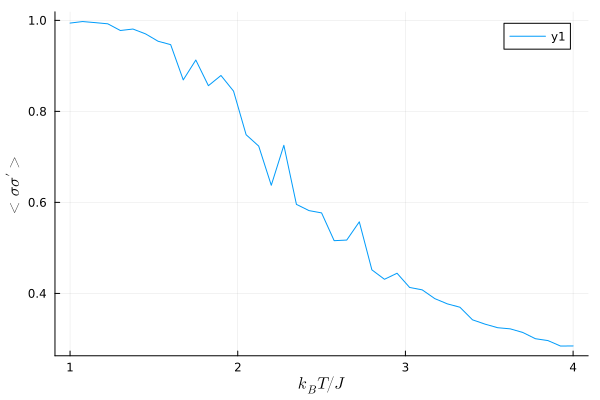

In [10]:
# メイン

# インデックスの定義
i = Index(2, "i")
j = Index(2, "j")
k = Index(2, "k")
l = Index(2, "l")

# 定数の定義
J = 1.0
k_B = 1.0
T_C = 2.0 / log(1 + sqrt(2))
T = range(1.0, 4.0, length = 41)
K_C = J / k_B / T_C
K = J ./ k_B ./ T
L = 10
chi = 200
Ls = [1]
m = []
mm = []

# 計算

for Ks in K
    W, P, C = tensor_origin_fix(Ks, i, j, k, l)

    for LL in 2:L
        # 拡大
        C = expand_tensor_2legs(W, P, C, i, j, k, l)
        P = expand_tensor_3legs(W, P, i, j, k, l)

        # 圧縮
        if 2^LL > chi
            C, P = compress_expansion(C, P, chi)
        end
    end

    # 測定
    push!(mm, measure_spin_correlation(W, P, C, i, j, k, l))

    # メモリの解法
    GC.gc()
end

plot(T, mm, xlabel = L"k_BT/J", ylabel = L"<\sigma\sigma^\prime>", title = "")

In [13]:
savefig("spin_correlation_TN.png")

"c:\\Users\\ito23\\Documents\\学院科目\\物性物理学特論Ⅰ\\Julia\\day4\\Mypackage\\spin_correlation_TN.png"

In [14]:
# インデックスの定義
i = Index(2, "i")
j = Index(2, "j")

# テンソルの作成
T = ITensor(i, j)
T[i => 1, j => 1] = 1.0 + 2.0im
T[i => 2, j => 1] = 3.0 - 1.0im
T[i => 1, j => 2] = -1.0 + 0.5im
T[i => 2, j => 2] = 2.0 + 3.0im

println("元のテンソル:")
println(T)

# エルミート共役を計算（複素共役 + 転置）
T_dag = dag(T)
T_hermitian = permute(T_dag, j, i)  # インデックスの順序を入れ替える

println("エルミート共役:")
println(T_hermitian)

T_T = real(0.5 * (T + T_hermitian))  # エルミート平均を計算
println("エルミート平均:")
println(T_T)

元のテンソル:
ITensor ord=2
Dim 1: (dim=2|id=321|"i")
Dim 2: (dim=2|id=246|"j")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2
 1.0 + 2.0im  -1.0 + 0.5im
 3.0 - 1.0im   2.0 + 3.0im
エルミート共役:
ITensor ord=2
Dim 1: (dim=2|id=246|"j")
Dim 2: (dim=2|id=321|"i")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2
  1.0 - 2.0im  3.0 + 1.0im
 -1.0 - 0.5im  2.0 - 3.0im
エルミート平均:
ITensor ord=2
Dim 1: (dim=2|id=321|"i")
Dim 2: (dim=2|id=246|"j")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 1.0  -1.0
 3.0   2.0
